# Example of DenseCRF with non-RGB data

This notebook goes through an example of how to use DenseCRFs on non-RGB data.
At the same time, it will explain basic concepts and walk through an example, so it could be useful even if you're dealing with RGB data, though do have a look at [PyDenseCRF's README](https://github.com/lucasb-eyer/pydensecrf#pydensecrf) too!

# Basic setup

It is highly recommended you install PyDenseCRF through pip, for example `pip install git+https://github.com/lucasb-eyer/pydensecrf.git`, but if for some reason you couldn't, you can always use it like so after compiling it:

In [2]:
#import sys
#sys.path.insert(0,'/path/to/pydensecrf/')

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Unary Potential

The unary potential consists of per-pixel class-probabilities. This could come from any kind of model such as a random-forest or the softmax of a deep neural network.

## Create unary potential

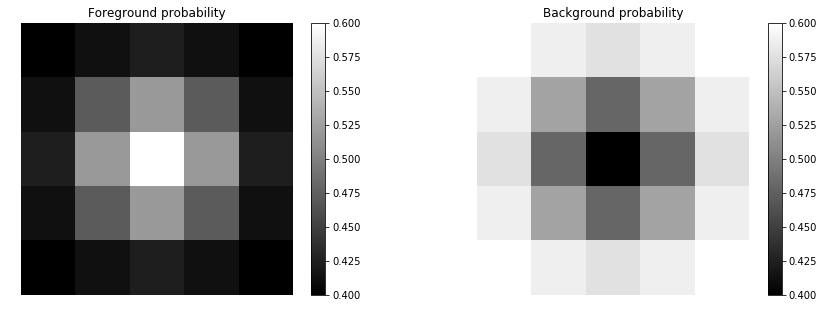

In [23]:
from scipy.stats import multivariate_normal

H, W, NLABELS = 5, 5, 2

# This creates a gaussian blob...
pos = np.stack(np.mgrid[0:H, 0:W], axis=2)
rv = multivariate_normal([H//2, W//2], (H//4)*(W//4))
probs = rv.pdf(pos)

# ...which we project into the range [0.4, 0.6]
probs = (probs-probs.min()) / (probs.max()-probs.min())
probs = 0.5 + 0.2 * (probs-0.5)

# The first dimension needs to be equal to the number of classes.
# Let's have one "foreground" and one "background" class.
# So replicate the gaussian blob but invert it to create the probability
# of the "background" class to be the opposite of "foreground".
probs = np.tile(probs[np.newaxis,:,:],(2,1,1))
probs[1,:,:] = 1 - probs[0,:,:]

# Let's have a look:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1); plt.imshow(probs[0,:,:]); plt.title('Foreground probability'); plt.axis('off'); plt.colorbar();
plt.subplot(1,2,2); plt.imshow(probs[1,:,:]); plt.title('Background probability'); plt.axis('off'); plt.colorbar();

## Run inference with unary potential

We can already run a DenseCRF with only a unary potential.
This doesn't account for neighborhoods at all, so it's not the greatest idea, but we can do it:

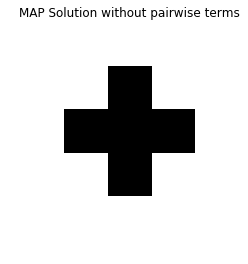

In [24]:
# Inference without pair-wise terms
U = unary_from_softmax(probs)  # note: num classes is first dim
d = dcrf.DenseCRF2D(W, H, NLABELS)
d.setUnaryEnergy(U)

# Run inference for 10 iterations
Q_unary = d.inference(10)

# The Q is now the approximate posterior, we can get a MAP estimate using argmax.
map_soln_unary = np.argmax(Q_unary, axis=0)

# Unfortunately, the DenseCRF flattens everything, so get it back into picture form.
map_soln_unary = map_soln_unary.reshape((H,W))

# And let's have a look.
plt.imshow(map_soln_unary); plt.axis('off'); plt.title('MAP Solution without pairwise terms');

# Pairwise terms

The whole point of DenseCRFs is to use some form of content to smooth out predictions. This is done via "pairwise" terms, which encode relationships between elements.

## Add (non-RGB) pairwise term

For example, in image processing, a popular pairwise relationship is the "bilateral" one, which roughly says that pixels with either a similar color or a similar location are likely to belong to the same class.

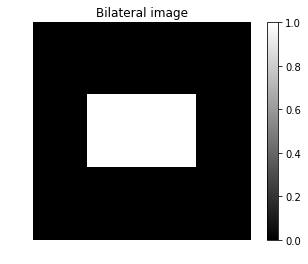

In [19]:
NCHAN=1

# Create simple image which will serve as bilateral.
# Note that we put the channel dimension last here,
# but we could also have it be the first dimension and
# just change the `chdim` parameter to `0` further down.
img = np.zeros((H,W,NCHAN), np.uint8)
img[H//3:2*H//3,W//4:3*W//4,:] = 1

plt.imshow(img[:,:,0]); plt.title('Bilateral image'); plt.axis('off'); plt.colorbar();

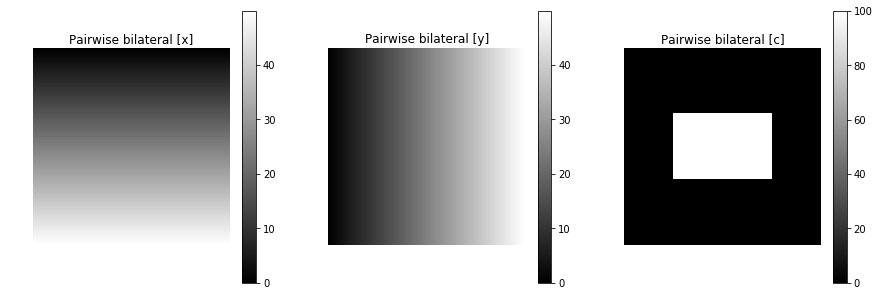

In [20]:
# Create the pairwise bilateral term from the above image.
# The two `s{dims,chan}` parameters are model hyper-parameters defining
# the strength of the location and image content bilaterals, respectively.
pairwise_energy = create_pairwise_bilateral(sdims=(10,10), schan=(0.01,), img=img, chdim=2)

# pairwise_energy now contains as many dimensions as the DenseCRF has features,
# which in this case is 3: (x,y,channel1)
img_en = pairwise_energy.reshape((-1, H, W))  # Reshape just for plotting
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img_en[0]); plt.title('Pairwise bilateral [x]'); plt.axis('off'); plt.colorbar();
plt.subplot(1,3,2); plt.imshow(img_en[1]); plt.title('Pairwise bilateral [y]'); plt.axis('off'); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(img_en[2]); plt.title('Pairwise bilateral [c]'); plt.axis('off'); plt.colorbar();

## Run inference of complete DenseCRF

Now we can create a dense CRF with both unary and pairwise potentials and run inference on it to get our final result.

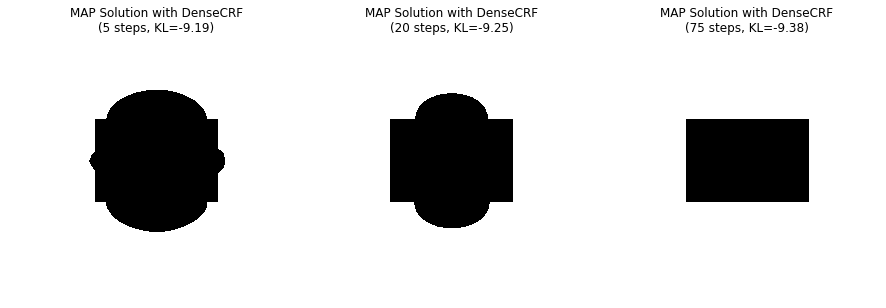

In [22]:
d = dcrf.DenseCRF2D(W, H, NLABELS)
d.setUnaryEnergy(U)
d.addPairwiseEnergy(pairwise_energy, compat=10)  # `compat` is the "strength" of this potential.

# This time, let's do inference in steps ourselves
# so that we can look at intermediate solutions
# as well as monitor KL-divergence, which indicates
# how well we have converged.
# PyDenseCRF also requires us to keep track of two
# temporary buffers it needs for computations.
Q, tmp1, tmp2 = d.startInference()
for _ in range(5):
    d.stepInference(Q, tmp1, tmp2)
kl1 = d.klDivergence(Q) / (H*W)
map_soln1 = np.argmax(Q, axis=0).reshape((H,W))

for _ in range(20):
    d.stepInference(Q, tmp1, tmp2)
kl2 = d.klDivergence(Q) / (H*W)
map_soln2 = np.argmax(Q, axis=0).reshape((H,W))

for _ in range(50):
    d.stepInference(Q, tmp1, tmp2)
kl3 = d.klDivergence(Q) / (H*W)
map_soln3 = np.argmax(Q, axis=0).reshape((H,W))

img_en = pairwise_energy.reshape((-1, H, W))  # Reshape just for plotting
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(map_soln1);
plt.title('MAP Solution with DenseCRF\n(5 steps, KL={:.2f})'.format(kl1)); plt.axis('off');
plt.subplot(1,3,2); plt.imshow(map_soln2);
plt.title('MAP Solution with DenseCRF\n(20 steps, KL={:.2f})'.format(kl2)); plt.axis('off');
plt.subplot(1,3,3); plt.imshow(map_soln3);
plt.title('MAP Solution with DenseCRF\n(75 steps, KL={:.2f})'.format(kl3)); plt.axis('off');